In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
import utils as u
u.check_python_version()
u.check_virtual_memory()

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 189 GB / percent used: 24.8 %


In [2]:
# Open a dataset with monthly data
ds = xr.open_dataset(
    'snowc.mon.noaaV2c_185101_201412_2.0x1.75.nc'
)
ds

<xarray.Dataset>
Dimensions:    (lat: 94, lon: 192, nbnds: 2, time: 1968)
Coordinates:
  * lat        (lat) float32 88.542 86.6531 84.7532 ... -86.6531 -88.542
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 354.375 356.25 358.125
  * time       (time) datetime64[ns] 1851-01-01 1851-02-01 ... 2014-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    snowc      (time, lat, lon) float32 ...
Attributes:
    Conventions:             CF-1.2
    title:                   4x Daily NOAA-CIRES 20th Century Reanalysis V2c
    platform:                Model
    institution:             NOAA ESRL Physical Sciences Division & CU/CIRES ...
    citation:                Compo,G.P. <http://www.esrl.noaa.gov/psd/people/...
    version:                 2c
    contact:                 esrl.psd.data@noaa.gov
    source:                  20CRv2c 2014, Ensemble Kalman Filter, ocean (spe...
    forcing_note:            Additional information on the exte

In [3]:
# Get the variable and perdiod
da = ds.snowc.sel(time=slice('1984', '2014'))
da

<xarray.DataArray 'snowc' (time: 372, lat: 94, lon: 192)>
[6713856 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * time     (time) datetime64[ns] 1984-01-01 1984-02-01 ... 2014-12-01
Attributes:
    long_name:         Monthly Snow Cover at Surface
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             %
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid


## Make month weights
http://xarray.pydata.org/en/stable/examples/monthly-means.html  
(bug leap year fixed: https://github.com/pydata/xarray/pull/3464)

In [4]:
# Days per month for different calendar types
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

In [5]:
# Deal with leap years
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar) and month == 2:
            month_length[i] += 1
    return month_length

In [6]:
# Make a DataArray with the number of days in each month, size = len(time)
month_length = xr.DataArray(get_dpm(da.time.to_index(), calendar='gregorian'),
                            coords=[da.time], name='month_length')
month_length

<xarray.DataArray 'month_length' (time: 372)>
array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31,
       28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30,
       31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30,
       31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31, 30,
       31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28,
       31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31,
       31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
       31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,

In [7]:
# Check leap year
import calendar

year = 2000

print(calendar.isleap(year))
month_length.sel(time=str(year))

True


<xarray.DataArray 'month_length' (time: 12)>
array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2000-12-01

## Yearly mean

### Compute the weights

In [8]:
da

<xarray.DataArray 'snowc' (time: 372, lat: 94, lon: 192)>
[6713856 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * time     (time) datetime64[ns] 1984-01-01 1984-02-01 ... 2014-12-01
Attributes:
    long_name:         Monthly Snow Cover at Surface
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             %
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid


In [9]:
import calendar as cld
cld.month_abbr[2]

'Feb'

In [10]:
season = 'DJF'
# season = 1

month_length = xr.DataArray(
    get_dpm(da.time.to_index(), calendar='gregorian'), coords=[da.time], name='month_length'
)
    
# Deal with custom season (string or int for single month)
month = da['time.month']

if isinstance(season, int):
    season_sel = (month == season)
    season_mean = da.sel(time=season_sel)
    
elif isinstance(season, str) and len(season) > 1:
    season_str = 'JFMAMJJASONDJFMAMJJASOND'

    month_start = season_str.index(season) + 1
    month_end = month_start + len(season) - 1

    if month_end > 12:
        # Remove one year ([month_end:-(12-month_start+1)]) to have continious months
        # The month/year label is from the starting month
        
        # Checked with cdo: !cdo yearmonmean -selmon,10,11,12 -shifttime,-2mo in.nc out.nc
        # -> slight differences, is CDO do not take the right month weights when shifted?
        # -> or do I use the wrong weights?
        # https://code.mpimet.mpg.de/boards/1/topics/826
        # 
        # !cdo yearmean -selmon,10,11,12 -shifttime,-2mo in.nc out.nc
        # Same results with the calendar=360_day

        month_end -= 12
        season_sel = (month >= month_start) | (month <= month_end)
        seasonal_data = da.sel(time=season_sel)[month_end:-(12-month_start+1)]
        seasonal_month_length = month_length.astype(float).sel(time=season_sel)[month_end:-(12-month_start+1)]
        weights = xr.DataArray(
            [value/seasonal_month_length.resample(time='AS-'+cld.month_abbr[month_start]).sum().values[i//len(season)] \
                 for i, value in enumerate(seasonal_month_length.values)],
            coords = [month_length.sel(time=season_sel)[month_end:-(12-month_start+1)].time],
            name = 'weights'
                              )
        sum_weights = weights.resample(time='AS-'+cld.month_abbr[month_start]).sum()
        np.testing.assert_allclose(sum_weights.values, np.ones(sum_weights.size))
        season_mean = (seasonal_data * weights).resample(time='AS-'+cld.month_abbr[month_start]).sum('time', skipna=False)
        
        
    else:
        # Checked with CDO (!cdo yearmonmean -selmonth,'' in.nc out.nc)
        season_sel = (month >= month_start) & (month <= month_end)
        seasonal_data = da.sel(time=season_sel)
        normalize = month_length.astype(float).sel(time=season_sel).groupby('time.year').sum()
        weights = month_length.sel(time=season_sel).groupby('time.year') / normalize
        np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(normalize.size))
        season_mean = (seasonal_data * weights).groupby('time.year').sum('time', skipna=False)
        

else:
    raise ValueError('The season is not valid (string or int for single month)')

In [11]:
season_mean

<xarray.DataArray (time: 30, lat: 94, lon: 192)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100

<IPython.core.display.Javascript object>


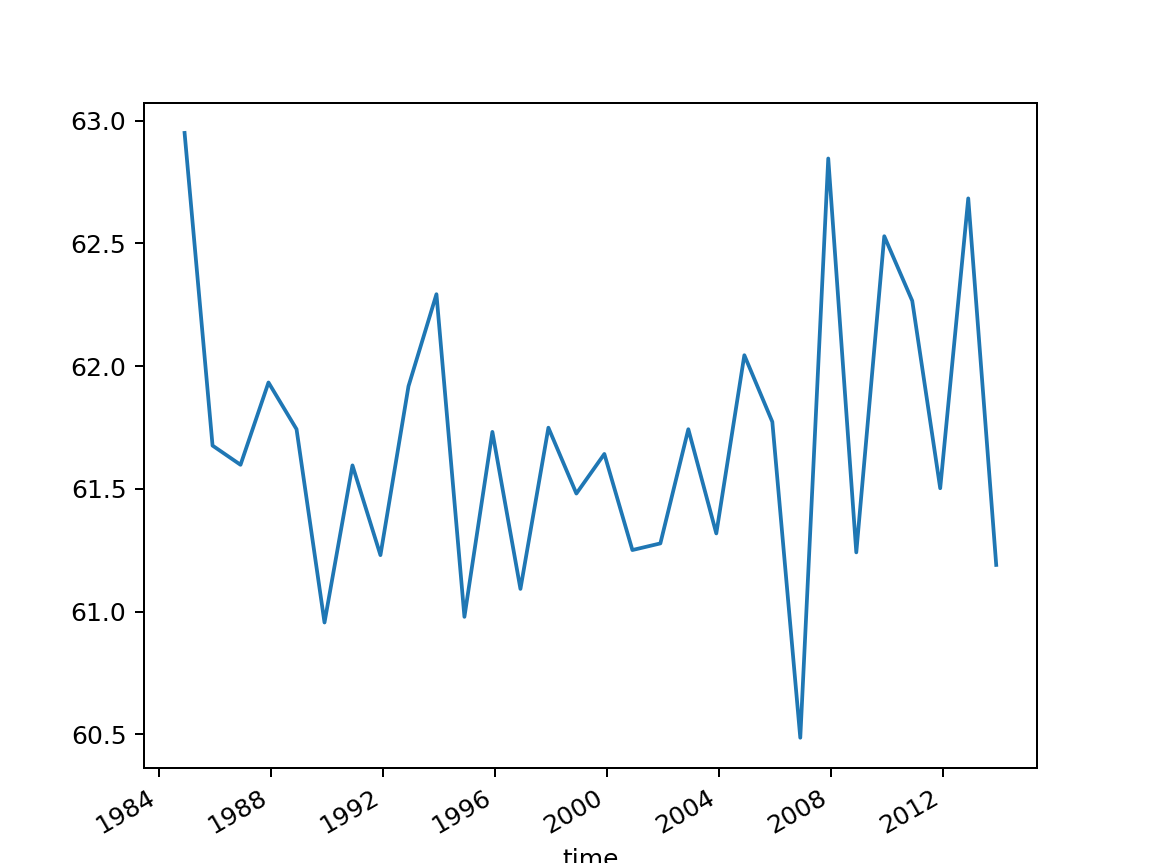

/home/mlalande/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [12]:
plt.figure()
season_mean.mean(dim=('lat','lon')).plot()

In [13]:
# !cdo yearmonmean -selmonth,'1' snowc.mon.noaaV2c_198401_201412_2.0x1.75.nc \
#                                    snowc.Jan_yearmonmean.noaaV2c_198401_201412_2.0x1.75.nc

In [14]:
# cdo = xr.open_dataset('snowc.Jan_yearmonmean.noaaV2c_198401_201412_2.0x1.75.nc').snowc
# cdo

In [15]:
# !cdo yearmonmean -selmonth,'12,1,2' snowc.mon.noaaV2c_198401_201412_2.0x1.75.nc \
#                                    snowc.DJF_yearmonmean.noaaV2c_198401_201412_2.0x1.75.nc

In [13]:
# https://code.mpimet.mpg.de/boards/1/topics/826
# Ok mais pas correct du coup avec yearmonmean qui ne va pas prendre en compte les bons mois...
# à moins que ce soit moi qui ne prenne pas en compte les bons poids...
!cdo yearmonmean -selmon,10,11,12 -shifttime,-2mo snowc.mon.noaaV2c_198401_201412_2.0x1.75.nc \
                                   snowc.DJF_yearmean_shifted.noaaV2c_198401_201412_2.0x1.75.nc

cdo(2) selmonth: Process started
cdo(3) shifttime: Process started
Warning (cdfDefVar): Changed double entry of variable name 'time_bnds' to 'time_bnds_2'!
cdo(3) shifttime: Processed 6714600 values from 2 variables over 372 timesteps
cdo(2) selmonth: Processed 1678650 values from 2 variables
cdo yearmonmean: Processed 1678650 values from 2 variables [0.45s 122MB]


In [14]:
cdo = xr.open_dataset('snowc.DJF_yearmonmean_shifted.noaaV2c_198401_201412_2.0x1.75.nc').snowc
cdo

<xarray.DataArray 'snowc' (time: 32, lat: 94, lon: 192)>
[577536 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1983-11-16 1984-11-01 ... 2014-10-01
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
Attributes:
    long_name:         Monthly Snow Cover at Surface
    units:             %
    cell_methods:      time: mean (monthly from 3-hourly values)
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actu

<IPython.core.display.Javascript object>


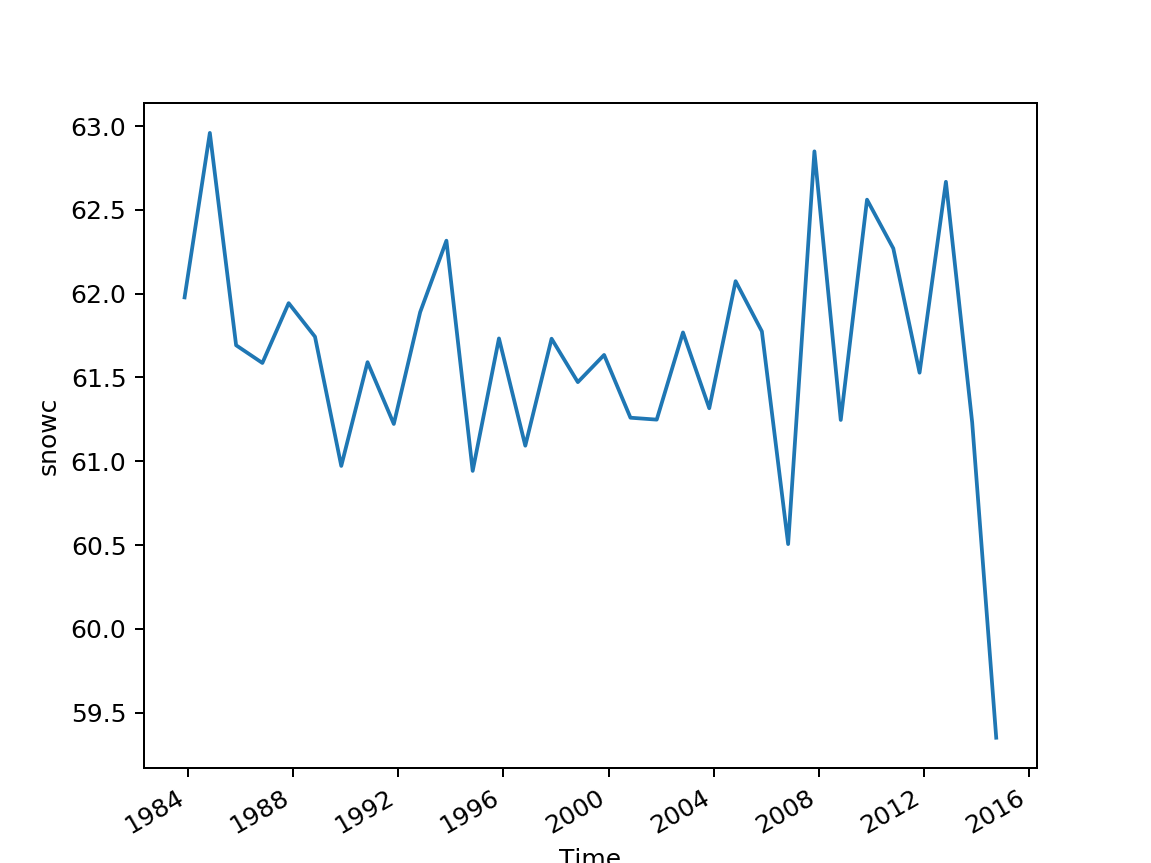

In [15]:
# CDO keeps not full seasons on left and right
plt.figure()
cdo.mean(dim=('lat','lon')).plot()

In [19]:
cdo.mean(dim=('lat','lon')).values[1:-1] - season_mean.mean(dim=('lat','lon')).values

array([ 0.00953556,  0.01616109, -0.01119132,  0.01051528,  0.00033179,
        0.01691121, -0.00405836, -0.00716931, -0.02829406,  0.02354998,
       -0.03602333,  0.00113496,  0.00074597, -0.01765575, -0.00835444,
       -0.00738011,  0.00936227, -0.02905467,  0.02597997, -0.00176725,
        0.03043698,  0.00228734,  0.01986338,  0.00370283,  0.00551756,
        0.03196373,  0.00435588,  0.02609719, -0.01543932,  0.04191786])

In [20]:
# cdo.mean(dim=('lat','lon')).values - season_mean.mean(dim=('lat','lon')).values

# Check with utils.season_mean()

In [16]:
# season_mean = u.season_mean(da, 'DJF', calendar='gregorian')
season_mean = u.year_mean(da, calendar='gregorian', season='DJF')
season_mean

<xarray.DataArray (time: 30, lat: 94, lon: 192)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100

<IPython.core.display.Javascript object>


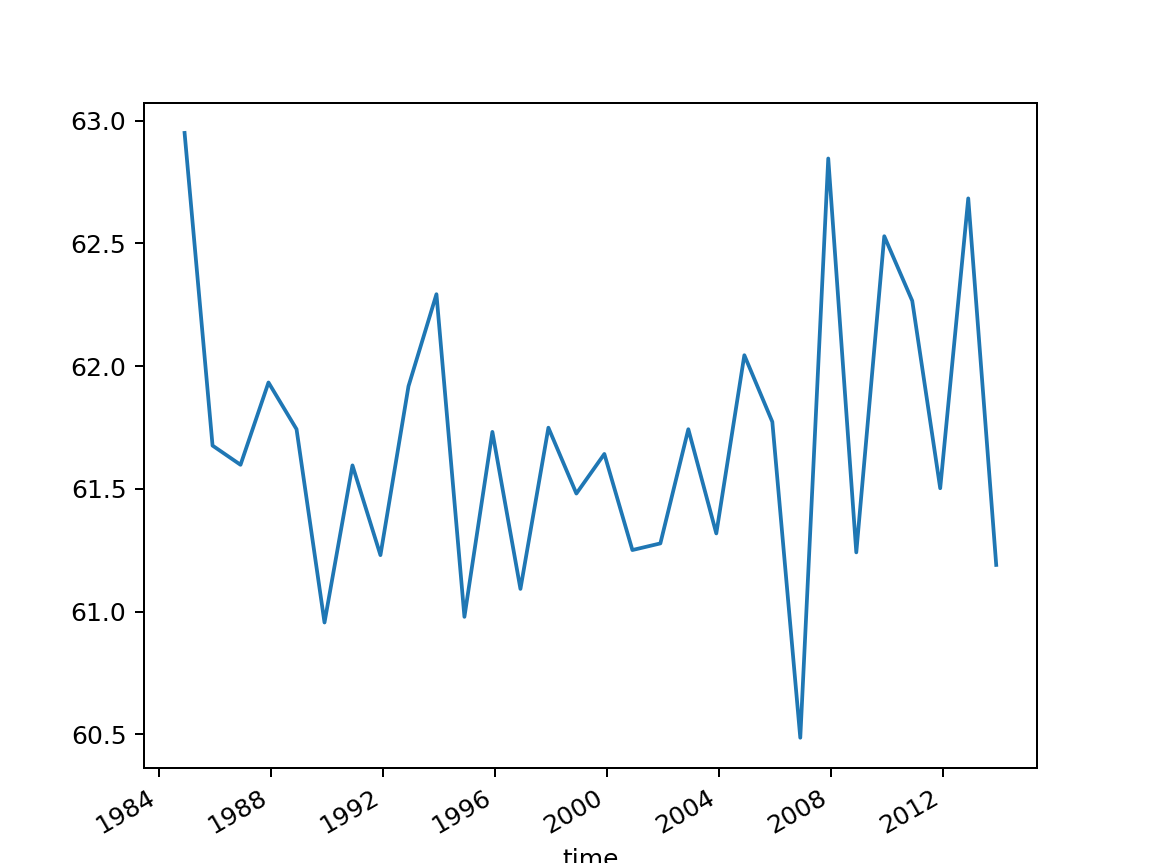

In [17]:
plt.figure()
season_mean.mean(dim=('lat','lon')).plot()

### Test with one month

In [18]:
year_mean_1 = u.year_mean(da, calendar='gregorian', season=1)
year_mean_1

<xarray.DataArray 'snowc' (time: 31, lat: 94, lon: 192)>
[559488 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * time     (time) datetime64[ns] 1984-01-01 1985-01-01 ... 2014-01-01
Attributes:
    long_name:         Monthly Snow Cover at Surface
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             %
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid
  

In [20]:
year_mean_1_cdo = xr.open_dataset('snowc.Jan_yearmonmean.noaaV2c_198401_201412_2.0x1.75.nc').snowc
year_mean_1_cdo

<xarray.DataArray 'snowc' (time: 31, lat: 94, lon: 192)>
[559488 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1984-01-01 1985-01-01 ... 2014-01-01
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
Attributes:
    long_name:         Monthly Snow Cover at Surface
    units:             %
    cell_methods:      time: mean (monthly from 3-hourly values)
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actu

In [37]:
u.spatial_average(year_mean_1) - u.spatial_average(year_mean_1_cdo)

<xarray.DataArray (time: 31)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1984-01-01 1985-01-01 ... 2014-01-01